## Pregunta 2

En esta sección se trabajará con el problema de predecir el salario de un anuncio laboral a partir de la descripción del empleo. El objetivo es tener un modelo que permita predecir el salario de cualquier anuncio laboral en el Reino Unido.

> a) Carge los datos *csv* de entrenamiento y cree un conjunto de validación con los últimos 10 mil datos en un dataframe de *pandas*. Describa los datos, apóyese de gráficos ¿Cuántos datos hay en cada conjunto? 

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [54]:
df = pd.read_csv("Train_rev1.csv")
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


El dataset se compone de 12 atributos, los cuales son:

+ Id: identificador único para cada anuncio laboral.
+ Title: título del aviso laboral.
+ FullDescription: texto completo del anuncio laboral.
+ LocationRaw: ubicación del empleo.
+ LocationNormalized: ubicación normalizada.
+ ContractType: tipo de contrato.
+ ContractTime: duración del contrato.
+ Company: nombre del empleador. 
+ Category: categoría del empleo.
+ SalaryRaw: salario.
+ SalaryNormalized: salario anual.
+ SourceName: nombre del sitio o anunciante que provee el aviso laboral.

In [55]:
df.shape

(244768, 12)

El dataset contiene 244.768 registros, cada uno con 12 atributos distintos.

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
Id                    244768 non-null int64
Title                 244767 non-null object
FullDescription       244768 non-null object
LocationRaw           244768 non-null object
LocationNormalized    244768 non-null object
ContractType          65442 non-null object
ContractTime          180863 non-null object
Company               212338 non-null object
Category              244768 non-null object
SalaryRaw             244768 non-null object
SalaryNormalized      244768 non-null int64
SourceName            244767 non-null object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


Del resumen del dataset se puede observar que ningún atributo cuenta con registros nulos. Además, dos de los atributos son de tipo númerico y el resto de los atributos son textos.

In [57]:
df.describe()

,Id,SalaryNormalized
count,2.447680e+05,244768.000000
mean,6.970142e+07,34122.577576
std,3.129813e+06,17640.543124
min,1.261263e+07,5000.000000
25%,6.869550e+07,21500.000000
50%,6.993700e+07,30000.000000
75%,7.162606e+07,42500.000000
max,7.270524e+07,200000.000000


De los atributos númericos, el que nos interesa para las predicciones es *SalaryNormalized*. El método `describe()` muestra las estadísticas para dicho atributo.

Para estudiar el comportamiento del atributo *SalaryNormalized* se realiza un boxplot.

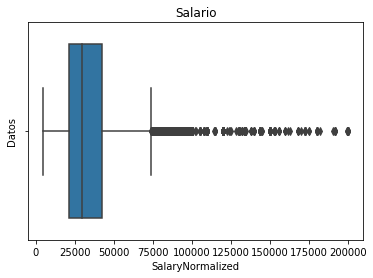

In [58]:
sns.boxplot(list(df.SalaryNormalized))
plt.ylabel('Datos')
plt.xlabel('SalaryNormalized')
plt.title('Salario')
plt.show()

Es evidente que los datos presentan un sesgo negativo bastante significativo. Tambien se aprecia la presencia de muchos outliers.

Para un primer acercamiento al problema, el dataset de entrenamiento se separará en un conjunto de entrenamiento con 15.000 registros y un conjunto de validación con 10.000 registros.

In [84]:
rows = np.random.choice(df.index.values, 15000, replace=False) #Elige 15000 filas al azar del df, no se repiten.

df_train = df.loc[rows]
df_val = df.iloc[-10000:]

print("Largo entrenamiento:", len(df_train.index), "|", "Largo validación:", len(df_val.index))

Largo entrenamiento: 15000 | Largo validación: 10000


> b) Extraiga los datos de cada conjunto con los que trabajará, el *input* $X$, los textos, y el *output* $Y$, los salarios.

A continuación, se separan los conjuntos de entrenamiento y validación en los respectivos inputs y outputs. Siendo el input $X$ el atributo *FullDescription* y el output $Y$ el atributo *SalaryNormalized*.

In [85]:
texto_train = df_train.FullDescription
salario_train = df_train.SalaryNormalized

texto_val = df_val.FullDescription
salario_val = df_val.SalaryNormalized

> c) Realice un pre-procesamiento a los datos brutos de texto para extraer características y generar la representación de los datos de entrada al modelo $\vec{x}$. Comente sobre lo realizado.

Para pre-procesar el texto se decidió utilizar la lematización debido a que considera el contexto de las palabras y puede resultar útil para el proceso de aprendizaje. Tambien se filtran las stopwords o palabras que no aportan significado al texto, mediante expresiones regulares se eliminan patrones como \*\*\*\* entre otros y se convierten las palabras a minúsculas. Por último, debido a la naturaleza del problema, se decide omitir las palabras cuyo largo sea mayor a 20 carácteres.

A continuación, se define la función `word_extractor` encargada del pre-procesamiento.

In [86]:
palabrasComunes = stopwords.words('english')

def word_extractor(text, commonwords):
    wordlemmatizer = WordNetLemmatizer()
    text = re.sub('\\*\\*\\*\\*|\\.|\\,|\\/|\\|', '',text) #elimina los **** del texto
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower())for word in word_tokenize(text) ]
    
    for word in wordtokens:
        if word not in commonwords and len(word) < 20:
            words+=" "+word
    return words

Se construyen las estructuras que serán utilizadas para el proceso de aprendizaje del modelo usando la función definida anteriormente.

In [87]:
start = time.time()

texts_train = [word_extractor(text, palabrasComunes) for text in texto_train]
texts_val = [word_extractor(text, palabrasComunes) for text in texto_val]

vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train))

features_train = vectorizer.transform(texts_train)
features_val = vectorizer.transform(texts_val)

labels_train = np.asarray(salario_train)
labels_val = np.asarray(salario_val)

print("Tiempo que tarda en ejecutarse:", round(time.time()-start, 1), "segundos")

Tiempo que tarda en ejecutarse: 64.8 segundos


In [88]:
features_train

<15000x42594 sparse matrix of type '<class 'numpy.int64'>'
	with 1637251 stored elements in Compressed Sparse Row format>

Se tiene una matriz dispersa para el input de entrenamiento.

In [89]:
vocab = vectorizer.get_feature_names()
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))
lista = zip(vocab, dist)
lista_ordenada = sorted(lista, key=lambda x: x[1], reverse=True)
lista_ordenada

[('experience', 11488),
 ('role', 9528),
 ('work', 9125),
 ('team', 9050),
 ('client', 8417),
 ('working', 8122),
 ('please', 7898),
 ('opportunity', 7797),
 ('skill', 7746),
 ('within', 7642),
 ('job', 7249),
 ('business', 6904),
 ('candidate', 6897),
 ('looking', 6797),
 ('service', 6552),
 ('company', 6427),
 ('excellent', 5970),
 ('required', 5611),
 ('management', 5594),
 ('apply', 5353),
 ('based', 5171),
 ('successful', 5170),
 ('must', 5102),
 ('development', 5010),
 ('manager', 5004),
 ('join', 4877),
 ('salary', 4874),
 ('new', 4777),
 ('uk', 4709),
 ('cv', 4693),
 ('support', 4686),
 ('level', 4632),
 ('environment', 4439),
 ('knowledge', 4421),
 ('position', 4411),
 ('strong', 4340),
 ('high', 4268),
 ('leading', 4222),
 ('ha', 4221),
 ('wa', 4190),
 ('ability', 4184),
 ('need', 4141),
 ('posted', 4079),
 ('originally', 4054),
 ('customer', 4053),
 ('also', 4049),
 ('contact', 4028),
 ('good', 4025),
 ('year', 3975),
 ('application', 3962),
 ('recruitment', 3909),
 ('includ

En la celda anterior se muestran las palabras más frecuentes del vocabulario generado.

> d) Intente resolver el problema enfrentándolo como regresión con el modelo de regresión lineal ordinaria en *sklearn*. ¿Qué es lo que hace *fit_intercept=True*? Evalúe la función objetivo (F.O.) utilizada y la métrica de la competencia (*mean absolute error*) en ambos conjuntos generados en el punto a). Comente lo observado.

Se procede a trabajar con un modelo de regresión lineal ordinaria. Para esto se utiliza el método `LinearRegression()` con parámetros `fit_intercept = True` y `normalize = False`. *fit_intercept* determina si se calcula el intercepto $\beta_0$ de la regresión lineal y solo debiese ser falso si se espera que los datos estén previamente centrados, por otra parte,*normalize* determina si se normalizan los regresores $X$ antes de realizar la regresión lineal.

In [90]:
start = time.time()

model = LinearRegression(fit_intercept=True, normalize=False)
model.fit(features_train, labels_train)

#measure MAE
print("MAE sobre entrenamiento: ", round(mean_absolute_error(labels_train, model.predict(features_train)), 1))
print("MAE sobre validación: ", round(mean_absolute_error(labels_val, model.predict(features_val)), 1))

print("Tiempo que tarda en ejecutarse:", round(time.time()-start, 1), "segundos")

MAE sobre entrenamiento:  20.9
MAE sobre validación:  24807.9
Tiempo que tarda en ejecutarse: 141.8 segundos


La métrica utilizada para evaluar el rendimiento del modelo corresponde al Error Absoluto Medio (MAE), cuya fórmula es:

$$
L = \frac{1}{N} \sum_i^N  \mid y_i - \hat{y}_i \mid
$$

Se interpreta como la distancia media entre las predicciones y los valores reales. En este caso, para el conjunto de validación se obtuvo un MAE bastante alto. Este valor puede deberse a usar pocos datos para el entrenamiento y/o un pre-procesamiento que no es adecuado.

En el siguiente inciso se propone una serie de cambios para mejorar el rendimiento del modelo y se discute el resultado obtenido.

> e) Intente mejorar sus resultados en base a la métrica de la competencia (MAE) sobre el conjunto de validación. Comente sobre lo realizado.  
*No se le pide que imite los resultados ganadores de la competencia (MAE de 3400), sino que mejore lo ya alcanzado siendo creativo.*

Los cambios que se proponen consisten en:
+ Eliminar los outliers para el conjunto de entrenamiento (el conjunto de validación se mantiene igual que en los incisos anteriores).
+ Eliminar palabras/símbolos que podrían estar generando ruido.

Primero se carga el dataset nuevo omitiendo los registros cuyo *SalaryNormalized* sea mayor a 68000. Este numero se obtiene sel boxplot realizado en los incisos anteriores.

In [66]:
df_nuevo = df[df.SalaryNormalized <= 68000]
df_nuevo.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


A continuación, se construye nuevamente el boxplot

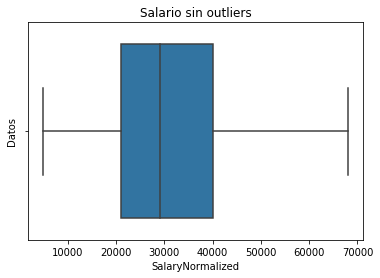

In [67]:
sns.boxplot(list(df_nuevo.SalaryNormalized))
plt.ylabel('Datos')
plt.xlabel('SalaryNormalized')
plt.title('Salario sin outliers')
plt.show()

Como se puede apreciar, no queda ningun outlier y la distribución de los datos se asemeja más a una normal. Esto facilitará el proceso de aprendizaje del modelo

Luego, se repite el procedimiento realizado en los incisos anteriores usando el nuevo dataset para evaluar si existe una mejora respecto al primer modelo.

In [92]:
rows_nuevo = np.random.choice(df_nuevo.index.values, 15000, replace=False) #Elige 15000 filas al azar del df_nuevo, no se repiten.

df_train_nuevo = df_nuevo.loc[rows_nuevo] ##el conjunto de entrenamiento se obtiene del dataset sin outliers
df_val_nuevo = df.iloc[-10000:] ##El conjunto de validación es el mismo que el anterior

print("Largo entrenamiento:", len(df_train_nuevo.index), "|", "Largo validación:", len(df_val_nuevo.index))

Largo entrenamiento: 15000 | Largo validación: 10000


In [93]:
texto_train_nuevo = df_train_nuevo.FullDescription
salario_train_nuevo = df_train_nuevo.SalaryNormalized

texto_val_nuevo = df_val_nuevo.FullDescription
salario_val_nuevo = df_val_nuevo.SalaryNormalized

In [94]:
palabrasComunes = stopwords.words('english')
palabrasRuido = [":", ".", ",", ";", "12", "10", ]

def word_extractor2(text, commonWords, noiseWords):
    wordlemmatizer = WordNetLemmatizer()
    text = re.sub('\\*\\*\\*\\*|\\/|\\|', '',text)
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower())for word in word_tokenize(text) ]
    
    for word in wordtokens:
        if word not in commonWords and word not in noiseWords and len(word) < 20:
            words+=" "+word
    return words

In [95]:
start = time.time()

texts_train_nuevo = [word_extractor2(text, palabrasComunes, palabrasRuido) for text in texto_train_nuevo]
texts_val_nuevo = [word_extractor2(text, palabrasComunes, palabrasRuido) for text in texto_val_nuevo]

vectorizer2 = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer2.fit(np.asarray(texts_train_nuevo))

features_train_nuevo = vectorizer2.transform(texts_train_nuevo)
features_val_nuevo = vectorizer2.transform(texts_val_nuevo)

labels_train_nuevo = np.asarray(salario_train_nuevo)
labels_val_nuevo = np.asarray(salario_val_nuevo)

print("Tiempo que tarda en ejecutarse:", round(time.time()-start, 1), "segundos")

Tiempo que tarda en ejecutarse: 80.8 segundos


In [96]:
start = time.time()

model_nuevo = LinearRegression(fit_intercept=True, normalize=False)
model_nuevo.fit(features_train_nuevo, labels_train_nuevo)

#measure MAE
print("MAE sobre entrenamiento: ", round(mean_absolute_error(labels_train_nuevo, model_nuevo.predict(features_train_nuevo)), 1))
print("MAE sobre validación: ", round(mean_absolute_error(labels_val_nuevo, model_nuevo.predict(features_val_nuevo)), 1))

print("Tiempo que tarda en ejecutarse:", round(time.time()-start, 1), "segundos")

MAE sobre entrenamiento:  10.7
MAE sobre validación:  16546.4
Tiempo que tarda en ejecutarse: 116.3 segundos


En general, se obtiene una mejora considerable respecto al modelo anterior, llegando a haber una diferencia de 6000 en el MAE. Sin embargo, existen ocasiones en que el primer modelo obtiene mejores resultados que el segundo.

La idea de eliminar los outliers es hacer que el modelo sea mas estable, realizando así mejores predicciones.